In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import sys   #to ignore warnings
import os
sys.stderr = open(os.devnull, 'w')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,  make_scorer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
df = pd.read_csv(r"C:\Users\NSHAT\crossrealms - intern\datasets\5G NDD\5G-NDD.csv")

In [3]:
df.shape

(1215890, 52)

In [4]:
df.head()

,Unnamed: 0,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,Label,Attack Type,Attack Tool
0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
1,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
2,2,3,4.998020,4.998020,4.998020,4.998020,4.998020,4.998020,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
3,3,4,4.998037,4.998037,4.998037,4.998037,4.998037,4.998037,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
4,4,5,4.999453,4.999453,4.999453,4.999453,4.999453,4.999453,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign


In [5]:
df["Attack Type"].value_counts()

Attack Type
Benign            477737
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64

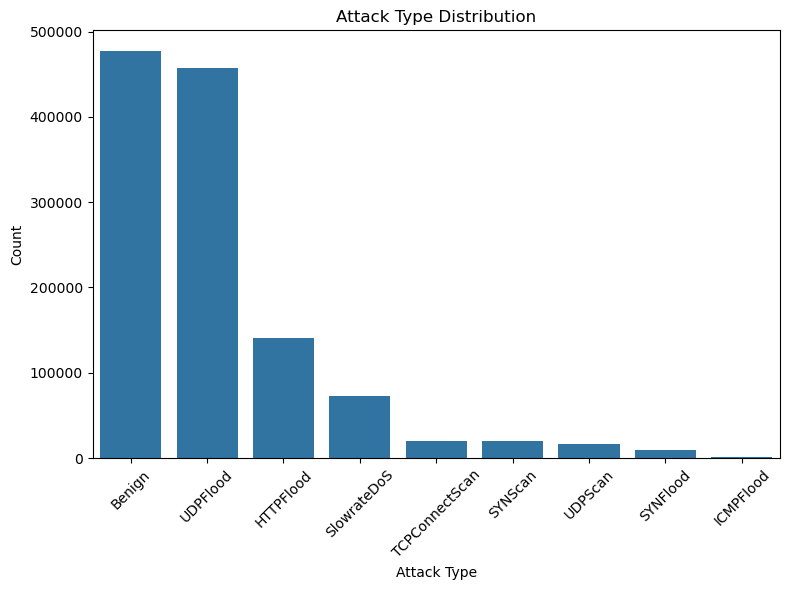

In [6]:
attack_counts = df["Attack Type"].dropna().value_counts()
attack_counts.index = attack_counts.index.astype(str)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=attack_counts.index, y=attack_counts.values)
plt.title("Attack Type Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
df["Label"].value_counts()

Label
Malicious    738153
Benign       477737
Name: count, dtype: int64

In [8]:
df["Attack Tool"].value_counts()

Attack Tool
Benign        477737
Hping3        468216
Goldeneye     140812
Torshammer     59870
Nmap           56001
Slowloris      13254
Name: count, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Data columns (total 52 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Unnamed: 0   1215890 non-null  int64  
 1   Seq          1215890 non-null  int64  
 2   Dur          1215890 non-null  float64
 3   RunTime      1215890 non-null  float64
 4   Mean         1215890 non-null  float64
 5   Sum          1215890 non-null  float64
 6   Min          1215890 non-null  float64
 7   Max          1215890 non-null  float64
 8   Proto        1215890 non-null  object 
 9   sTos         1215676 non-null  float64
 10  dTos         272823 non-null   float64
 11  sDSb         1215676 non-null  object 
 12  dDSb         272823 non-null   object 
 13  sTtl         1215676 non-null  float64
 14  dTtl         272823 non-null   float64
 15  sHops        1215676 non-null  float64
 16  dHops        272823 non-null   float64
 17  Cause        1215890 non-null  object 
 18  To

## fixing column names

In [10]:
df.columns = df.columns.str.strip()

In [11]:
df.drop(columns={"Unnamed: 0","Seq"},inplace = True)

## removing duplicates

In [12]:
df.duplicated().sum()

np.int64(3358)

In [13]:
df.drop_duplicates(inplace=True)

## Handling Missing Values

In [14]:
df.isna().sum()

Dur                  0
RunTime              0
Mean                 0
Sum                  0
Min                  0
Max                  0
Proto                0
sTos               214
dTos            939709
sDSb               214
dDSb            939709
sTtl               214
dTtl            939709
sHops              214
dHops           939709
Cause                0
TotPkts              0
SrcPkts              0
DstPkts              0
TotBytes             0
SrcBytes             0
DstBytes             0
Offset               0
sMeanPktSz           0
dMeanPktSz           0
Load                 0
SrcLoad              0
DstLoad              0
Loss                 0
SrcLoss              0
DstLoss              0
pLoss                0
SrcGap          933861
DstGap          933861
Rate                 0
SrcRate              0
DstRate              0
State                0
SrcWin          970112
DstWin         1035454
sVid           1099840
dVid           1210523
SrcTCPBase      933861
DstTCPBase 

In [15]:
from sklearn.feature_selection import mutual_info_classif
'''
X = df.drop(columns=['Attack Type', 'Label', 'Attack Tool'])  
y = df['Attack Type']

# fill NaNs with a value (median for numeric, mode for categorical) - (in X)
for col in X.select_dtypes(include=['float64', 'int64']):
    X[col].fillna(X[col].median(), inplace=True)
for col in X.select_dtypes(include=['object']):
    X[col].fillna('Unknown', inplace=True)

# Convert categorical columns to category dtype or encode them
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category').cat.codes

# calc info gain
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({'Feature': X.columns, 'InfoGain': mi_scores})
mi_df = mi_df.sort_values(by='InfoGain', ascending=False)
print(mi_df)'''
# importance of feats , to decide how to deal with missing values in some columns
# too long run time 

"\nX = df.drop(columns=['Attack Type', 'Label', 'Attack Tool'])  \ny = df['Attack Type']\n\n# fill NaNs with a value (median for numeric, mode for categorical) - (in X)\nfor col in X.select_dtypes(include=['float64', 'int64']):\n    X[col].fillna(X[col].median(), inplace=True)\nfor col in X.select_dtypes(include=['object']):\n    X[col].fillna('Unknown', inplace=True)\n\n# Convert categorical columns to category dtype or encode them\nfor col in X.select_dtypes(include=['object']).columns:\n    X[col] = X[col].astype('category').cat.codes\n\n# calc info gain\nmi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)\n\nmi_df = pd.DataFrame({'Feature': X.columns, 'InfoGain': mi_scores})\nmi_df = mi_df.sort_values(by='InfoGain', ascending=False)\nprint(mi_df)"

In [16]:
#dropping unimportant feats with alot of missing values
drop_cols = ['dVid', 'sVid', 'SrcGap', 'DstGap', 'dTos', 'pLoss', 'Loss', 'SrcLoss', 'DstLoss']
df.drop(columns=drop_cols, inplace=True)

In [17]:
# numirical feats - fill by median
median_fill_cols = ['SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin', 'sTtl', 'dTtl', 'sHops', 'dHops']
for col in median_fill_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

In [18]:
# for the cols with very few missing values - filling with mode or constant
cols = ['sDSb', 'sTos']
for col in cols:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0]) 
        else:
            df[col] = df[col].fillna(df[col].median())  

### Label Encoding for catogrical feats and the target variable

In [19]:
le = LabelEncoder()
for col in ['Attack Tool']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

In [20]:
# List your categorical columns
cat_cols = ['Proto', 'State', 'Cause', 'sDSb', 'dDSb', 'Label']

# Apply LabelEncoder to each
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure string type

In [21]:
# also saving to inverse later
df['Attack Type'] = le.fit_transform(df['Attack Type'].astype(str))
attack_type_classes = le.classes_

In [22]:
df["Attack Type"].value_counts()

Attack Type
0    475510
7    456214
1    140812
5     73124
6     20052
4     20043
8     15901
3      9721
2      1155
Name: count, dtype: int64

## splitting into train test sets

In [23]:
X = df.drop(columns=['Attack Type', 'Label', 'Attack Tool'])  # Exclude these
y = df['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Standarizing

In [24]:
categorical_encoded = ['Proto', 'State', 'Cause', 'sDSb', 'dDSb']
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
features_to_scale = numeric_cols.difference(categorical_encoded)

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

### dimensionality reduction - PCA

In [25]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# modeling 

### Random Forest

In [26]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9785325784410347
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     95102
           1       0.99      1.00      1.00     28163
           2       1.00      1.00      1.00       231
           3       1.00      1.00      1.00      1944
           4       1.00      1.00      1.00      4009
           5       0.99      0.99      0.99     14625
           6       1.00      1.00      1.00      4010
           7       0.97      0.97      0.97     91243
           8       1.00      1.00      1.00      3180

    accuracy                           0.98    242507
   macro avg       0.99      0.99      0.99    242507
weighted avg       0.98      0.98      0.98    242507



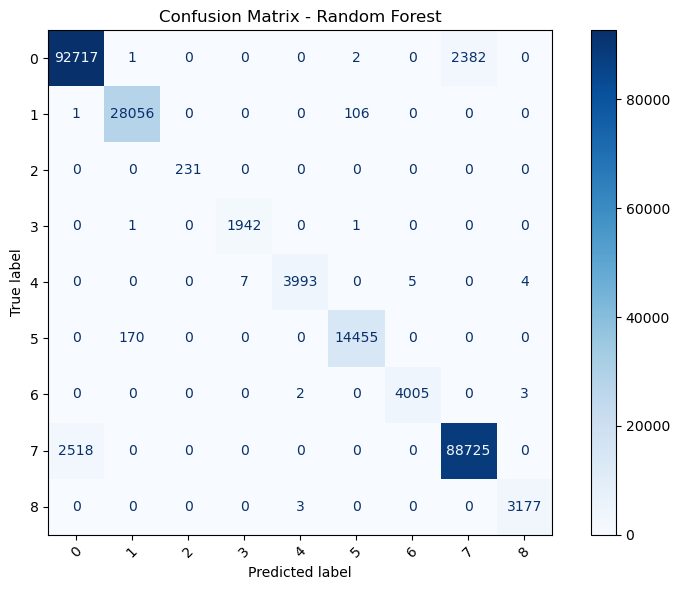

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# cm
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.tight_layout()
plt.show()


### XGBoost Classifier

In [28]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_pca, y_train)

y_pred_xgb = xgb_clf.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.9836911924191879
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     95102
           1       0.99      1.00      1.00     28163
           2       1.00      1.00      1.00       231
           3       1.00      1.00      1.00      1944
           4       1.00      1.00      1.00      4009
           5       0.99      0.99      0.99     14625
           6       1.00      1.00      1.00      4010
           7       0.97      1.00      0.98     91243
           8       1.00      1.00      1.00      3180

    accuracy                           0.98    242507
   macro avg       0.99      0.99      0.99    242507
weighted avg       0.98      0.98      0.98    242507



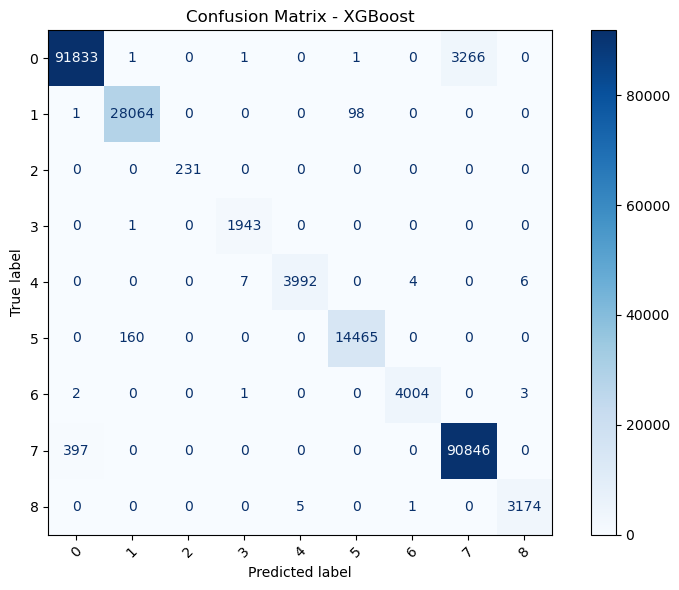

In [29]:
cm = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.tight_layout()
plt.show()

### k-cross validation to insure no overfitting 

In [30]:
# combining for k cross validation
X_pca = np.vstack((X_train_pca, X_test_pca))
y_all = np.hstack((y_train, y_test))

xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracy scores from each fold
scores = cross_val_score(xgb_clf, X_pca, y_all, cv=kf, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
print("Standard Deviation:", np.std(scores))

Cross-Validation Accuracy Scores: [0.98341079 0.98317162 0.98402101 0.98380246 0.98374061]
Mean Accuracy: 0.9836292985885645
Standard Deviation: 0.0003010093913214845
